In [18]:
import os
import yaml
import random

import numpyro
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from priorCVAE.priors import SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params
from experiments.zimbabwe.zimbabwe_utility import read_data, plot_prior_samples, plot_statistics

import jax.config as config
config.update("jax_enable_x64", True)


In [19]:
output_dir = "../outputs/l3skrqpq/"
data_path = "../data/zimbabwe_admin2/shapefile.shp"
conditional = True
latent_dim = 60

In [20]:
def get_vae_samples(decoder, trained_decoder_params, ls, conditional):
    key = jax.random.PRNGKey(random.randint(0, 9999))
    rng, z_rng, init_rng = jax.random.split(key, 3)
    z = jax.random.normal(z_rng, (5000, latent_dim))
    if conditional:
        c = ls * jnp.ones((z.shape[0], 1))
        z = jnp.concatenate([z, c], axis=-1)
    vae_samples = decoder.apply({'params': trained_decoder_params}, z)
    
    return vae_samples

In [21]:
def get_sample_ls():
    a = numpyro.distributions.Uniform(0, 1)#Gamma(4, 2)
    key = jax.random.PRNGKey(random.randint(0, 9999))
    _, z_rng = jax.random.split(key, 2)
    ls = a.sample(z_rng, (1,))
    return ls

In [22]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]

In [23]:
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=nn.tanh)

In [24]:
x, data_frame = read_data(data_path, normalize=True)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [25]:
data_generator = GPDataset(kernel=SquaredExponential(), x=x, sample_lengthscale=False)
batch_x_train, batch_y_train, batch_ls_train = data_generator.simulatedata(n_samples=1000)

## Plot marginals

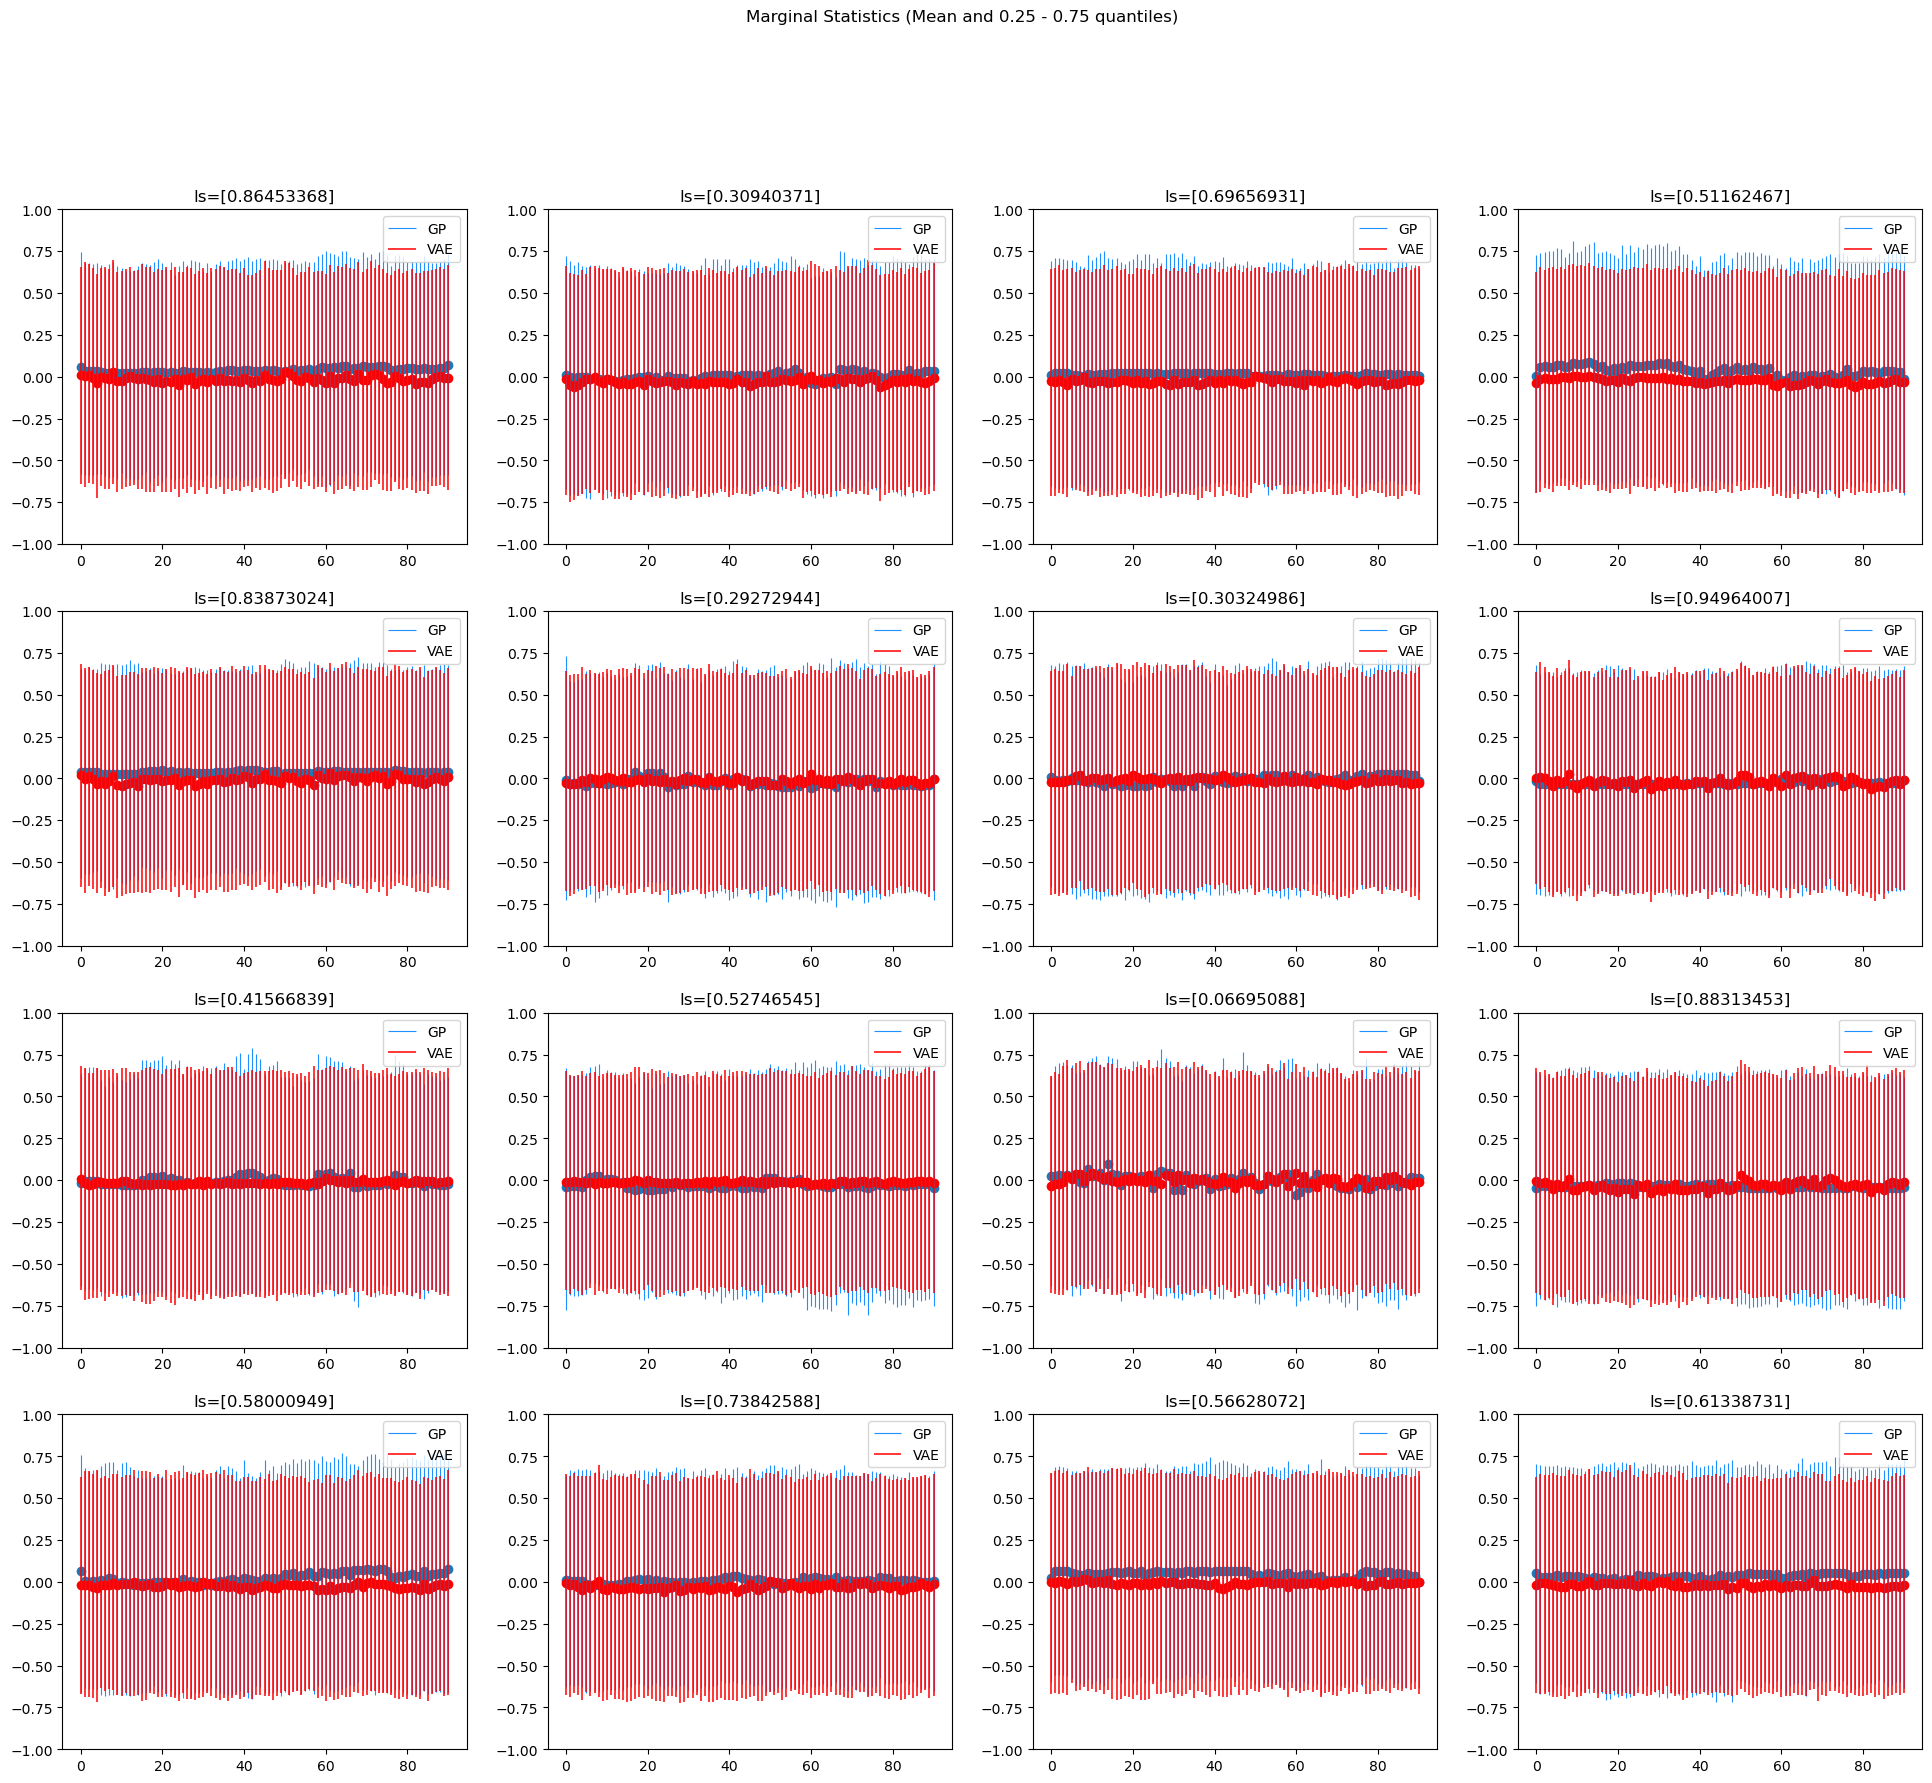

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))

for i in range(16):
    rows = int(i//4)
    cols = int(i%4)
    
    ls = get_sample_ls()
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=1000)
    
    gp_samples_mean = jnp.mean(prior_samples, axis=0)
    gp_draws_25, gp_draws_75 = jnp.quantile(prior_samples, jnp.array([.25, .75]), axis=0)

    vae_samples_mean = jnp.mean(vae_samps, axis=0)
    vae_draws_25, vae_draws_75 = jnp.quantile(vae_samps, jnp.array([.25, .75]), axis=0)

    axs[rows][cols].scatter(jnp.arange(len(gp_samples_mean)), gp_samples_mean)
    axs[rows][cols].scatter(jnp.arange(len(vae_samples_mean)), vae_samples_mean, color="red")

    axs[rows][cols].vlines(x=jnp.arange(len(gp_draws_25)),
               ymin=gp_draws_25,
               ymax=gp_draws_75,
               color="dodgerblue",
               label="GP",
               linewidth=0.8)

    axs[rows][cols].vlines(x=jnp.arange(len(vae_draws_25)),
               ymin=vae_draws_25,
               ymax=vae_draws_75,
               color="red",
               label="VAE",
               linewidth=1.1)
    axs[rows][cols].legend()
    axs[rows][cols].set_title(f"ls={ls}")
    axs[rows][cols].set_ylim([-1, 1])

plt.suptitle("Marginal Statistics (Mean and 0.25 - 0.75 quantiles)")
plt.show()

## Plot Cov

In [27]:
def normalize_data(x):
#     return x
    x_normalized = (x - jnp.min(x))/(jnp.max(x) - jnp.min(x))
    return x_normalized

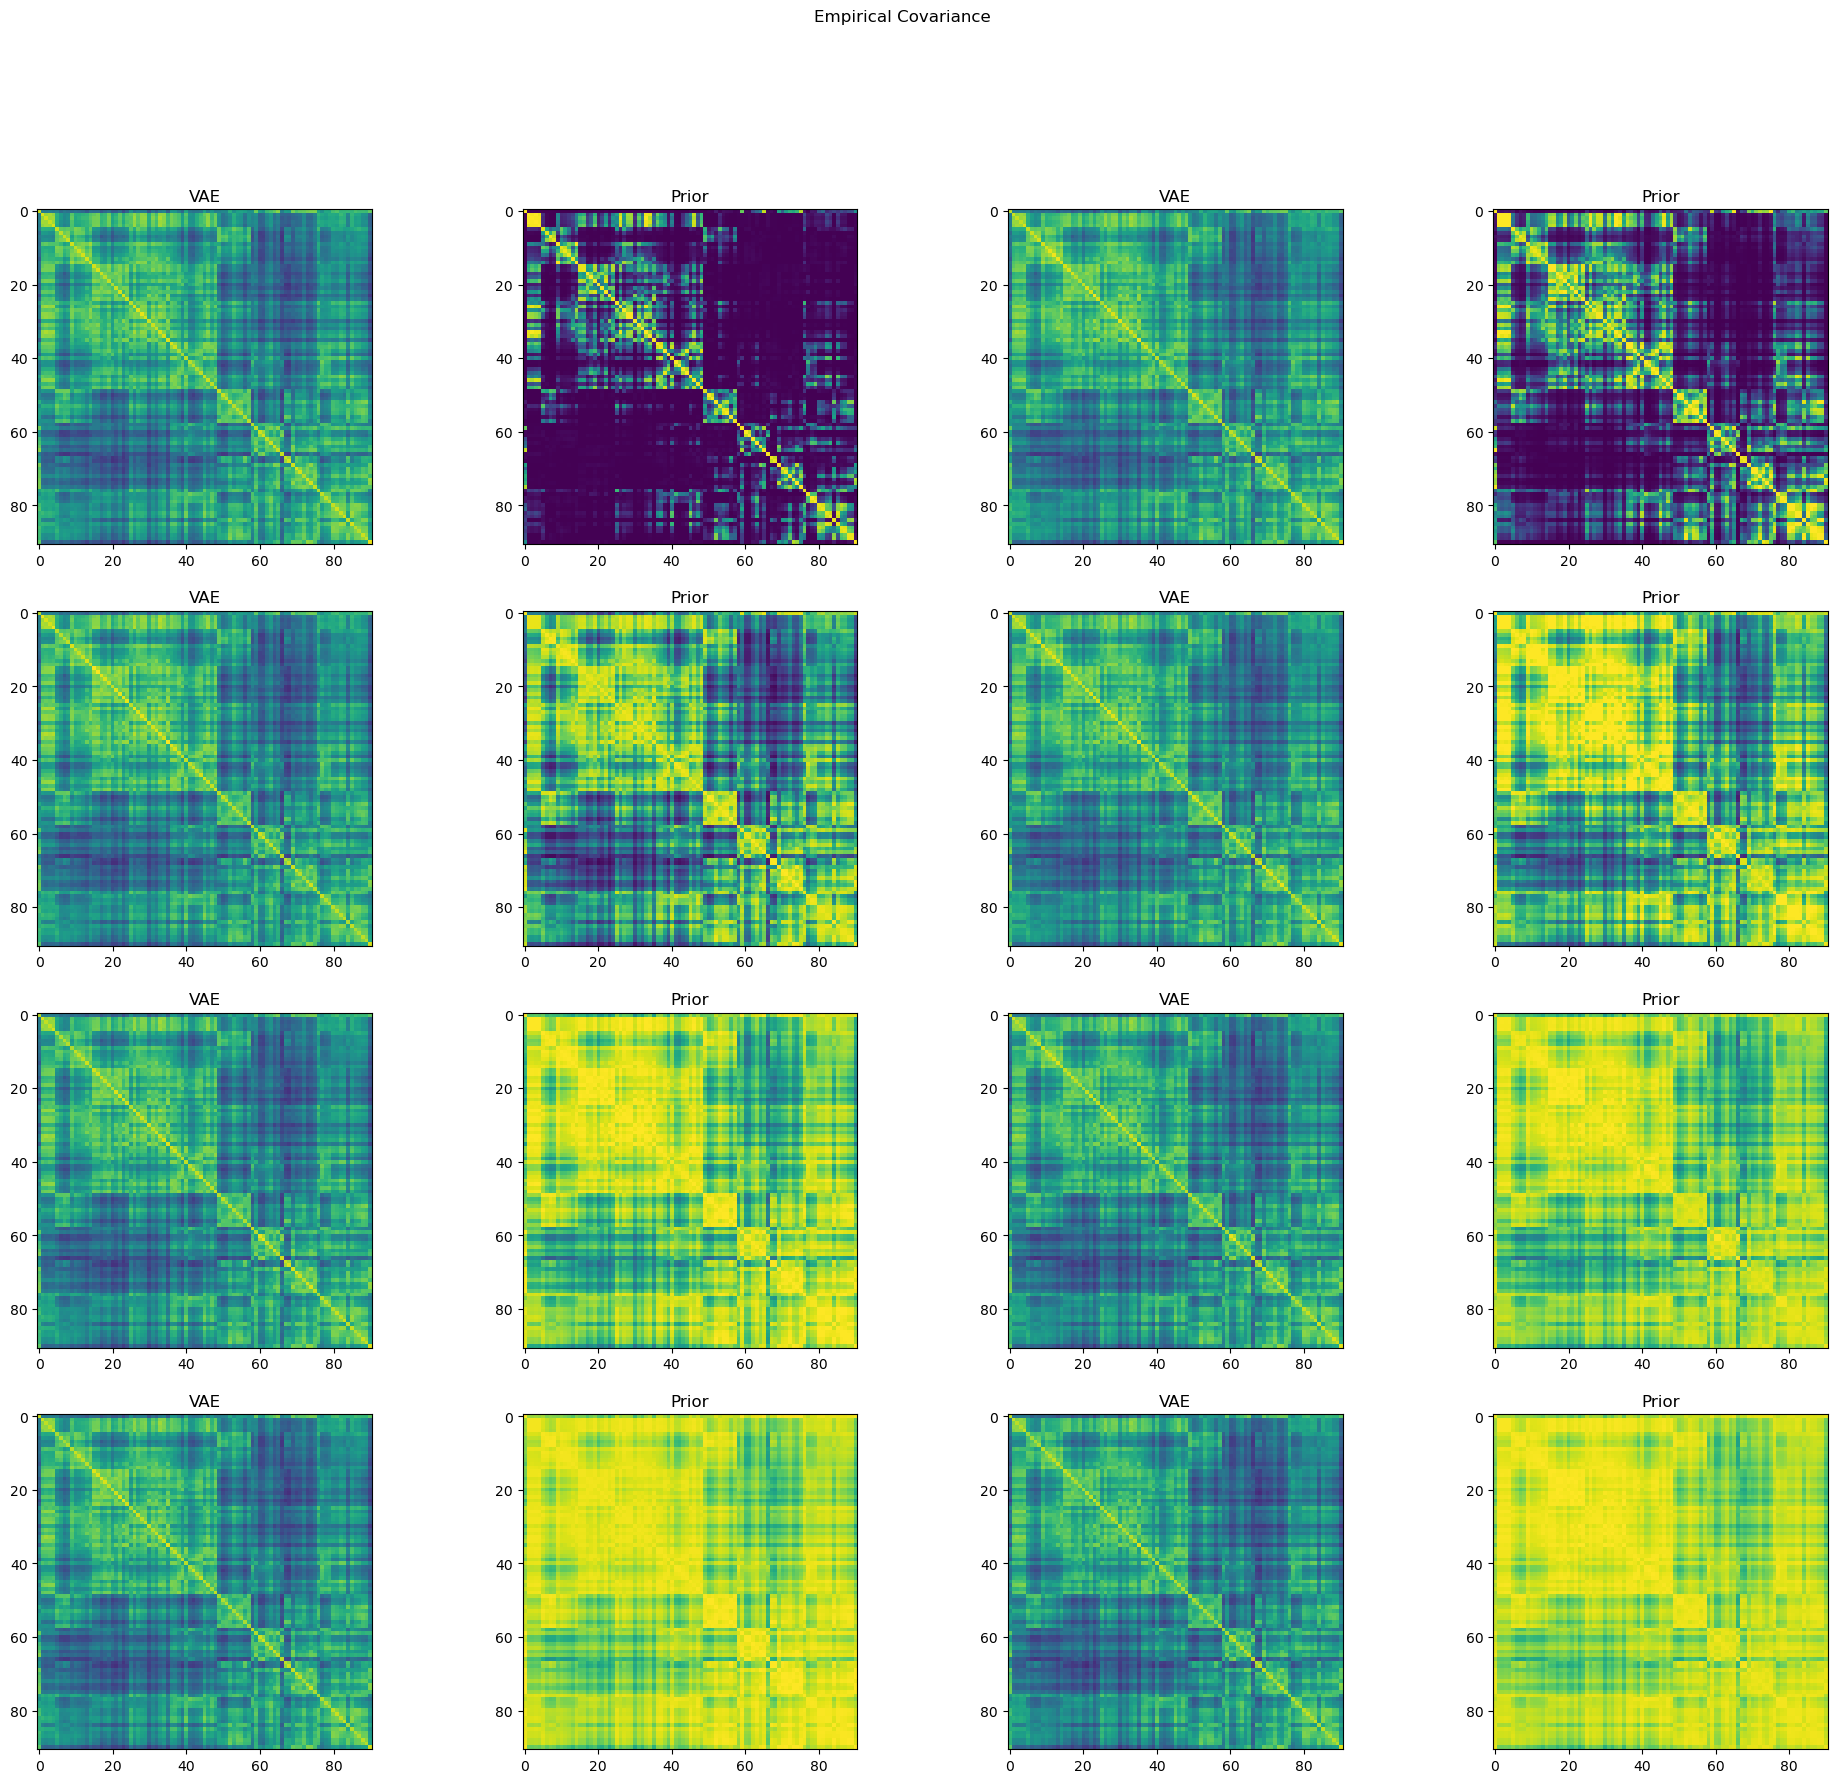

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(24, 20))
cols = 2
ls_list = jnp.linspace(0, 1, 16)
for i in range(16):
    rows = int(i//4)
    cols = 0 if cols==2 else 2
    
    ls = ls_list[i] #get_sample_ls()
    data_generator.kernel.lengthscale = ls
    
    vae_samps = get_vae_samples(decoder, trained_decoder_params, ls, conditional)
    _, prior_samples, _ = data_generator.simulatedata(n_samples=5000)
    
    vae_cov = jnp.cov(vae_samps.T)
    prior_cov = jnp.cov(prior_samples.T)
#     vae_cov_normalized = normalize_data(vae_cov)
#     prior_cov_normalized = normalize_data(prior_cov)
    
#     print(jnp.max(vae_cov))
#     print(jnp.max(prior_cov_normalized))
    
    axs[rows][cols].imshow(vae_cov, vmin=0, vmax=1)
    axs[rows][cols].set_title("VAE")
    axs[rows][cols + 1].imshow(prior_cov, vmin=0, vmax=1)
    axs[rows][cols + 1].set_title("Prior")
    
plt.suptitle("Empirical Covariance")
plt.show()

## Plot Prior

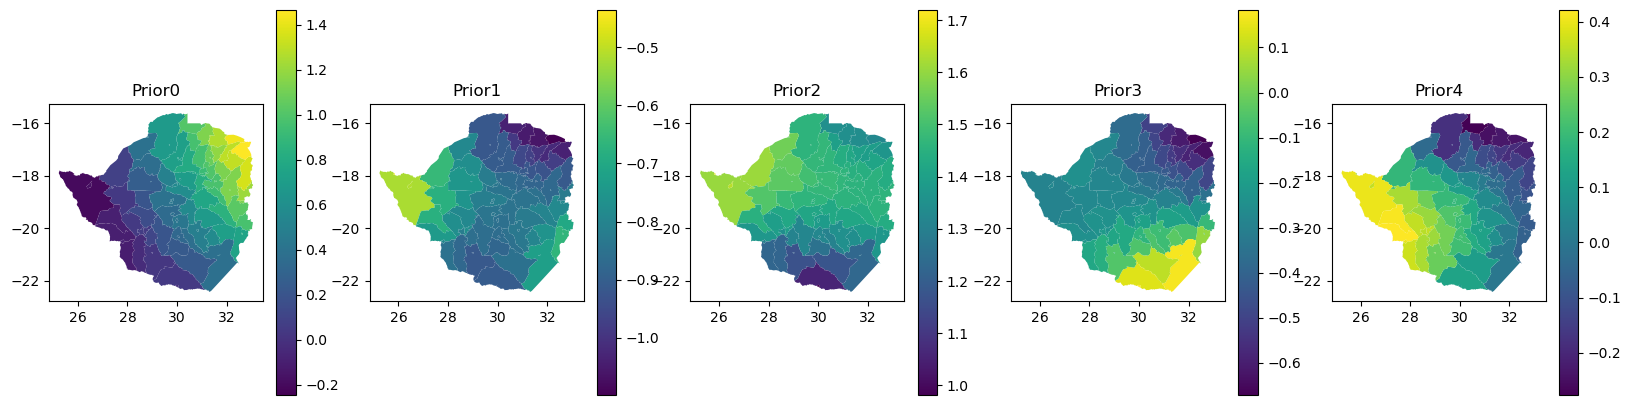

In [12]:
plot_prior_samples(data_frame, batch_y_train)